In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time
import random
import scipy

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from numpy.fft import fftn

## Homemade code imports
import metrics

data_dir = '/run/media/mnewlin/_userdata/uhnds/'
original_netflow_data_dir = data_dir + 'host/unconverted/'
original_netflow_file = 'netflow_day-02'
fake_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/fake/'
real_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/real/'
real_file = 'netflow_day-02'

real_host_dir = '/run/media/mnewlin/_userdata/uhnds/host/unconverted/real/tfidf/'
fake_host_dir = '/run/media/mnewlin/_userdata/uhnds/host/unconverted/fake'

results_dir = '/run/media/mnewlin/_userdata/results_data/results/'

# Dataset dependent number of cols
N_COLS = 20
np.seterr(all='ignore')

/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
"""
    Function to read in a single real sample from a given directory based
    on the desired length of the sample.
"""
def load_real_sample(sample_num, sample_length=100):

    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1
        
    load_file = real_file + '_sample_{}.txt'.format(sample_num)
    filename = real_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

def load_real_host_sample(sample_num, sample_length=1000):
    directory = '/run/media/mnewlin/_userdata/uhnds/host/unconverted/real/tfidf/'
    real_host_data_dir = 'samples_{}/'.format(sample_length)
        
    load_file = directory + real_host_data_dir + 'tfidf_sample_{}.csv'.format(sample_num)
    df = pd.read_csv(load_file, dtype=np.float64)
    data = np.array(df)
    return data

def load_fake_host_sample(sample_num, sample_length=1000,dist='uniform'):
    directory = '/run/media/mnewlin/_userdata/uhnds/host/unconverted/fake/{}/'.format(dist)
    
    fake_host_data_dir = directory + 'samples_{}/'.format(sample_length)
        
    load_file = fake_host_data_dir + 'tfidf_sample_{}.csv'.format(sample_num)
    df = pd.read_csv(load_file, dtype=np.float64)
    data = np.array(df)
    return data
"""
    Function to read in a single fake sample from a given directory based
    on the desired length of the sample.
"""
def load_fake_sample(sample_num, sample_length=100):
    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1

    load_file = real_file + '_random_sample_{}.txt'.format(sample_num)
    filename = fake_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

def load_n_host_samples(real=True, sample_length=100, num_samples=100, random_state=69, dist='uniform'):

    sample_set = np.array([])
    sample_range= 10000
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = load_real_host_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    else:
        for num in sample_list:
            data = None
            if dist == 'uniform':
                data = load_fake_host_sample(sample_length=sample_length, sample_num=num, dist='uniform')
            else:
                data = load_fake_host_sample(sample_length=sample_length, sample_num=num, dist='normal')
            sample_set = np.append(sample_set, data)
    sample_set = np.reshape(sample_set, newshape=(num_samples, sample_length, N_COLS))
        
    return sample_set

def load_n_samples(real=True, sample_length=100, num_samples=100, random_state=69):
    
    sample_set = np.array([])
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    # Seed random samples for repeatability    
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = load_real_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    else:
        for num in sample_list:
            data = load_fake_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    sample_set = np.reshape(sample_set, newshape=(num_samples, sample_length, N_COLS))
    return sample_set

def create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    
    #mix_set = np.zeros((num_samples, sample_length, N_COLS))
    bound_val_real = np.around(((1-ratio)*num_samples), decimals=2)
    bound_val_fake = np.around((ratio)*num_samples, decimals=2)
    bound_val_real = int(bound_val_real) # How many real samples there should be
    bound_val_fake = int(bound_val_fake) # How many fake samples there should be
    
    real_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state) 
    fake_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state)
    real_section = real_data[:bound_val_real]
    fake_section = fake_data[:bound_val_real]
    mix_set = np.append(real_section, fake_section)
    mix_set = np.reshape(mix_set, newshape=(num_samples, sample_length, N_COLS))
    return mix_set

## Test Discriminative ability

Approach: Caclulate $n$ different distances between real sets: $\rho(R_i,R_j)$ and $n$ different distances between real and fake sets $\rho(R_i, F_j)$ for $i,j \leq n, i \neq j$.

Then compare the two distributions $P_1 = \rho(R_i,R_j)$ and $P_2 = \rho(R_i,F_j)$ with the Kullback Leibler distance (KLD) $\sum_x p_1(x)\log_a\frac{p_1(x)}{p_2(x)}$


## Repeatability Standpoint

### Untransformed

In [6]:
indir = results_dir + 'untrans/'
real_data_untrans = pd.read_csv(indir+'real_data_exp_host_normal.csv').drop(['Unnamed: 0','fid'], axis=1)
display(real_data_untrans.head())
fake_data_untrans = pd.read_csv(indir+'fake_data_exp_host_normal.csv').drop(['Unnamed: 0','fid'], axis=1)
display(fake_data_untrans.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,590.992823,32.033137,2.920854e+05,4472.751122,0.729486,5346.056656,0.017451,0.071082,4.821975,0.355130
1,425.041051,20.273839,2.509287e+05,3463.470656,0.729571,5631.874992,0.028650,0.257182,11.790535,0.282391
2,578.254941,30.757620,3.030064e+05,4470.019475,0.746244,5520.306762,0.030961,0.185519,11.625489,0.413442
3,487.300317,34.779531,1.724922e+05,3201.036523,0.768937,5433.687875,0.038753,1.102998,24.945510,0.441990
4,123729.906082,9111.937604,2.674130e+07,726779.600640,0.775043,5603.106220,0.031604,0.079901,5.516134,0.251136


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,933.871953,43.301961,696639.773082,8129.066754,0.663580,6313.424061,0.594111,0.174121,12.565097,0.286420
1,743.141787,30.970115,608390.225717,6768.097355,0.672757,6330.699377,0.518910,0.347985,18.673544,0.120268
2,958.846492,43.714454,723638.649082,8401.196219,0.669651,6348.819559,0.645422,0.236122,15.952048,0.392609
3,583.714240,23.008342,498493.330493,5427.425735,0.706333,6256.107961,0.542735,1.374534,29.906985,0.322394
4,798.269380,34.136602,643685.898493,7213.660501,0.658289,6343.951919,0.538382,0.165421,12.214347,0.249380


In [7]:
titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
         'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_untrans
fake_data = fake_data_untrans
num_metrics = 10
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    
    fig = plt.figure(figsize=(15,20))
    
    grid_x = 5
    grid_y = 2
    grid = mpl.gridspec.GridSpec(grid_x, grid_y)
    count = 0
    
    r = np.zeros((num_metrics, binsize-1))
    f = np.zeros((num_metrics, binsize-1))
    rr = 0
    rf = 0
    for j in range(grid_x):
        for k in range(grid_y):
            ax1 = plt.subplot(grid[j,k])
            if 'Natural' in labels[count]:
                rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            elif '10' in labels[count]:
                rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            else:
                rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
            best_bins_min = np.minimum(rr.min(), rf.min()) 
            best_bins_max = np.maximum(rr.max(), rf.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
            fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
            r[count] = real_hist_data[0]
            f[count] = fake_hist_data[0]
            ax1.set_xlabel(labels[count], fontsize=16)
            ax1.set_ylabel(y_label, fontsize=16)
            ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            count += 1
    rd = np.zeros((binsize-1, num_metrics))
    fd = np.zeros((binsize-1, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd  
    
    #plt.tight_layout()
    #plt.savefig('figures/discriminative/png/uhnds_host/untrans/hist_mat_vert_1000_1000_{}.png'.format(i))
    #plt.savefig('figures/discriminative/eps/uhnds_host/untrans/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    


Finished


In [8]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
JSD_data_untrans = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_untrans.at[:,'Mean'] = np.round(np.mean(JSD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
JSD_data_untrans.at[:,'Min'] = np.round(np.min(JSD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
JSD_data_untrans.at[:,'Max'] = np.round(np.max(JSD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
JSD_data_untrans.at[:,'Range'] = np.round(JSD_data_untrans.loc[:,'Max'] - JSD_data_untrans.loc[:,'Min'], 4)
#display(KLD_data_untrans)
JSD_stats_untrans = JSD_data_untrans.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_untrans)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_untrans_normal.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_untrans_stats_normal.csv'
JSD_data_untrans.to_csv(outfile)
JSD_stats_untrans.to_csv(outfile2)

,Mean,Min,Max,Range
Wasserstein,1.0000,1.0000,1.0000,0.0000
Mahalanobis,0.9799,0.8150,1.0000,0.1850
Cosine,0.9616,0.9449,0.9743,0.0294
$l_p$: $p=r=0.5$,0.9460,0.9328,0.9587,0.0259
$l_p$: $p=r=0.75$,0.8337,0.8161,0.8458,0.0297
Entropy,0.7092,0.6911,0.7374,0.0463
Manhattan,0.6880,0.6703,0.7082,0.0379
Perplexity,0.5338,0.5101,0.5474,0.0373
Euclidean,0.4177,0.4015,0.4332,0.0317
MMD,0.1838,0.1336,0.2149,0.0813


In [6]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
KLD_data_untrans = pd.DataFrame(KLD_data_all,index=names, columns=cols)

#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_untrans.at[:,'Mean'] = np.round(np.mean(KLD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
KLD_data_untrans.at[:,'Min'] = np.round(np.min(KLD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
KLD_data_untrans.at[:,'Max'] = np.round(np.max(KLD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
KLD_data_untrans.at[:,'Range'] = np.round(KLD_data_untrans.loc[:,'Max'] - KLD_data_untrans.loc[:,'Min'], 4)

#display(KLD_data_untrans)
KLD_stats_untrans = KLD_data_untrans.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_untrans)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_host_untrans_uniform.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_host_untrans_uniform_stats.csv'
KLD_data_untrans.to_csv(outfile)
KLD_stats_untrans.to_csv(outfile2)

,Mean,Min,Max,Range
Wasserstein,8.9103,8.8424,9.0459,0.2035
$l_p$: $p=r=0.5$,8.0627,7.7953,8.8476,1.0523
Mahalanobis,7.9011,7.4563,9.1734,1.7171
Cosine,6.9244,5.7240,8.1150,2.3910
$l_p$: $p=r=0.75$,5.3537,4.9465,5.7464,0.7999
Perplexity,5.3462,5.0215,5.5325,0.5110
Entropy,3.9400,3.7140,4.1735,0.4595
Manhattan,2.9208,2.4384,3.4377,0.9993
Euclidean,0.5154,0.4092,0.6398,0.2306
MMD,0.1278,0.0686,0.1610,0.0924


## SQRT Data

In [13]:
indir = results_dir + 'sqrt/'
real_data_sqrt = pd.read_csv(indir+'real_data_exp_host_normal.csv').drop(['Unnamed: 0','fid'], axis=1)
display(real_data_sqrt.head())
fake_data_sqrt = pd.read_csv(indir+'fake_data_exp_host_normal.csv').drop(['Unnamed: 0','fid'], axis=1)
display(fake_data_sqrt.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,541.329440,28.417349,2.730992e+05,4.163699e+03,0.720177,5349.563349,0.025063,0.062093,4.495712,0.247806
1,427.626890,20.535329,2.568107e+05,3.501310e+03,0.722647,5586.074910,0.041115,0.213811,9.570536,0.274134
2,481.324463,25.221703,2.629187e+05,3.783803e+03,0.741210,5432.409911,0.039645,0.246200,12.043945,0.396602
3,272.504883,15.977797,1.292481e+05,2.026336e+03,0.772368,5434.547624,0.057924,0.971037,23.683946,0.402880
4,179945.395546,13846.714972,3.738976e+07,1.039538e+06,0.763747,5561.662152,0.048313,0.071175,5.139938,0.247322


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,875.469048,39.979419,675450.437689,7736.205008,0.659986,6309.950365,0.571833,0.148349,10.988474,0.232850
1,737.446179,30.489176,607132.016627,6738.064620,0.669360,6314.775630,0.506840,0.313064,16.868015,0.083723
2,867.411467,37.940228,685963.621854,7770.749152,0.667300,6324.632810,0.579058,0.182391,13.369845,0.332176
3,595.755318,23.652957,505297.612404,5522.061280,0.711902,6252.401209,0.552106,1.234150,28.025663,0.302100
4,849.989533,37.882767,668508.782513,7582.794148,0.654835,6334.836080,0.547902,0.172001,12.367642,0.247183


In [14]:
titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
         'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_sqrt
fake_data = fake_data_sqrt
num_metrics = 10
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    
    fig = plt.figure(figsize=(15,20))
    
    grid_x = 5
    grid_y = 2
    grid = mpl.gridspec.GridSpec(grid_x, grid_y)
    count = 0
    
    r = np.zeros((num_metrics, binsize-1))
    f = np.zeros((num_metrics, binsize-1))
    rr = 0
    rf = 0
    for j in range(grid_x):
        for k in range(grid_y):
            ax1 = plt.subplot(grid[j,k])
            if 'Natural' in labels[count]:
                rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            elif '10' in labels[count]:
                rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            else:
                rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
            best_bins_min = np.minimum(rr.min(), rf.min()) 
            best_bins_max = np.maximum(rr.max(), rf.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
            fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
            r[count] = real_hist_data[0]
            f[count] = fake_hist_data[0]
            ax1.set_xlabel(labels[count], fontsize=16)
            ax1.set_ylabel(y_label, fontsize=16)
            ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            count += 1
    rd = np.zeros((binsize-1, num_metrics))
    fd = np.zeros((binsize-1, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd  
    
    #plt.tight_layout()
    #plt.savefig('figures/discriminative/png/uhnds_host/sqrt/normal/hist_mat_vert_1000_1000_{}.png'.format(i))
    #plt.savefig('figures/discriminative/eps/uhnds_host/sqrt/normal/hist_mat_vert_1000_1000_{}.eps'.format(i))
    #plt.savefig('figures/discriminative/eps/uhnds_host/sqrt/normal/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    
    

Finished


In [15]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
JSD_data_sqrt = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_sqrt.at[:,'Mean'] = np.round(np.mean(JSD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
JSD_data_sqrt.at[:,'Min'] = np.round(np.min(JSD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
JSD_data_sqrt.at[:,'Max'] = np.round(np.max(JSD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
JSD_data_sqrt.at[:,'Range'] = np.round(JSD_data_sqrt.loc[:,'Max'] - JSD_data_sqrt.loc[:,'Min'], 4)
#display(KLD_data_untrans)
JSD_stats_sqrt = JSD_data_sqrt.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_sqrt_normal.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_sqrt_stats_normal.csv'
JSD_data_sqrt.to_csv(outfile)
JSD_stats_sqrt.to_csv(outfile2)

,Mean,Min,Max,Range
Wasserstein,1.0000,1.0000,1.0000,0.0000
Mahalanobis,0.9814,0.8221,1.0000,0.1779
Cosine,0.9571,0.9400,0.9700,0.0300
$l_p$: $p=r=0.5$,0.9568,0.9452,0.9639,0.0187
$l_p$: $p=r=0.75$,0.8863,0.8761,0.9082,0.0321
Manhattan,0.8090,0.7865,0.8221,0.0356
Euclidean,0.6425,0.6186,0.6558,0.0372
Entropy,0.6144,0.5986,0.6295,0.0309
Perplexity,0.4710,0.4443,0.4875,0.0432
MMD,0.1896,0.1535,0.2180,0.0645


In [25]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
KLD_data_sqrt = pd.DataFrame(KLD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_sqrt.at[:,'Mean'] = np.round(np.mean(KLD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
KLD_data_sqrt.at[:,'Min'] = np.round(np.min(KLD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
KLD_data_sqrt.at[:,'Max'] = np.round(np.max(KLD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
KLD_data_sqrt.at[:,'Range'] = np.round(KLD_data_sqrt.loc[:,'Max'] - KLD_data_sqrt.loc[:,'Min'], 4)

KLD_stats_sqrt = KLD_data_sqrt.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_sqrt)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_host_uniform_sqrt.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results__host_uniform_sqrt_stats.csv'
KLD_data_sqrt.to_csv(outfile)
KLD_stats_sqrt.to_csv(outfile2)

,Mean,Min,Max,Range
Wasserstein,8.6879,8.6102,8.8451,0.2349
$l_p$: $p=r=0.5$,8.3817,8.0197,9.2153,1.1956
Mahalanobis,7.9130,7.4735,9.2128,1.7393
$l_p$: $p=r=0.75$,7.0549,6.8089,7.3767,0.5678
Cosine,6.7401,5.3704,7.8285,2.4581
Manhattan,5.6909,5.2858,6.0173,0.7315
Perplexity,3.2053,2.8795,3.4537,0.5742
Euclidean,2.6697,2.3419,2.9337,0.5918
Entropy,2.5598,2.3947,2.7361,0.3414
MMD,0.1111,0.0576,0.1537,0.0961


## Log Results

In [19]:
indir = results_dir + 'log/'
real_data_log = pd.read_csv(indir+'real_data_exp_host_normal.csv').drop(['Unnamed: 0','fid'], axis=1)
display(real_data_log.head())
fake_data_log = pd.read_csv(indir+'fake_data_exp_host_normal.csv').drop(['Unnamed: 0','fid'], axis=1)
display(fake_data_log.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,575.678823,30.931968,2.874268e+05,4377.868774,0.729121,5342.093246,0.016703,0.068898,4.692285,0.347861
1,419.419480,19.880224,2.495385e+05,3428.755844,0.729532,5624.670468,0.027413,0.216824,9.786899,0.282502
2,557.164398,29.403759,2.949443e+05,4326.042425,0.746214,5507.926394,0.029383,0.231021,12.565048,0.414639
3,460.583717,32.647788,1.652990e+05,3040.458223,0.769915,5427.876917,0.035990,1.099098,24.733004,0.442224
4,127023.323665,9371.854835,2.739441e+07,745505.833591,0.774067,5598.333521,0.030398,0.078838,5.454309,0.250696


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,916.355556,42.194362,689192.907962,8006.879987,0.658356,6321.880328,0.589816,0.179628,12.953685,0.282566
1,733.109108,30.350998,602181.045868,6689.257171,0.668528,6333.318203,0.512526,0.315663,17.202767,0.101461
2,933.158869,42.131958,710918.111394,8213.404752,0.665509,6348.871515,0.629817,0.294995,17.757719,0.384868
3,571.595936,22.266015,490209.578800,5326.942693,0.705147,6259.824135,0.541058,1.381051,30.362768,0.332176
4,796.652557,34.052189,642620.163563,7200.269546,0.653890,6351.120334,0.537735,0.170749,12.538689,0.249157


In [20]:

subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_log
fake_data = fake_data_log
num_metrics = 10
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    
    fig = plt.figure(figsize=(15,20))
    
    grid_x = 5
    grid_y = 2
    grid = mpl.gridspec.GridSpec(grid_x, grid_y)
    count = 0
    
    r = np.zeros((num_metrics, binsize-1))
    f = np.zeros((num_metrics, binsize-1))
    rr = 0
    rf = 0
    for j in range(grid_x):
        for k in range(grid_y):
            ax1 = plt.subplot(grid[j,k])
            if 'Natural' in labels[count]:
                rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            elif '10' in labels[count]:
                rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            else:
                rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
            best_bins_min = np.minimum(rr.min(), rf.min()) 
            best_bins_max = np.maximum(rr.max(), rf.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
            fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
            r[count] = real_hist_data[0]
            f[count] = fake_hist_data[0]
            ax1.set_xlabel(labels[count], fontsize=16)
            ax1.set_ylabel(y_label, fontsize=16)
            ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            count += 1
    rd = np.zeros((binsize-1, num_metrics))
    fd = np.zeros((binsize-1, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd  
    
    #plt.tight_layout()
    #plt.savefig('figures/discriminative/png/uhnds_host/log/normal/hist_mat_vert_1000_1000_{}.png'.format(i))
    #plt.savefig('figures/discriminative/eps/uhnds_host/log/normal/hist_mat_vert_1000_1000_{}.eps'.format(i))
    #plt.savefig('figures/discriminative/eps/uhnds_host/log/normal/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    
    

Finished


In [21]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
JSD_data_log = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_log.at[:,'Mean'] = np.round(np.mean(JSD_data_log.loc[:,:'Run 10'], axis=1), 4)
JSD_data_log.at[:,'Min'] = np.round(np.min(JSD_data_log.loc[:,:'Run 10'], axis=1), 4)
JSD_data_log.at[:,'Max'] = np.round(np.max(JSD_data_log.loc[:,:'Run 10'], axis=1), 4)
JSD_data_log.at[:,'Range'] = np.round(JSD_data_log.loc[:,'Max'] - JSD_data_log.loc[:,'Min'], 4)
#display(KLD_data_untrans)
JSD_stats_log = JSD_data_log.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_log)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_log_normal.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_log_stats_normal.csv'
JSD_data_log.to_csv(outfile)
JSD_stats_log.to_csv(outfile2)

,Mean,Min,Max,Range
Wasserstein,1.0000,1.0000,1.0000,0.0000
Mahalanobis,0.9806,0.8177,1.0000,0.1823
Cosine,0.9626,0.9477,0.9768,0.0291
$l_p$: $p=r=0.5$,0.9475,0.9317,0.9567,0.0250
$l_p$: $p=r=0.75$,0.8442,0.8286,0.8587,0.0301
Entropy,0.7179,0.7007,0.7332,0.0325
Manhattan,0.7107,0.6925,0.7355,0.0430
Perplexity,0.5569,0.5353,0.5739,0.0386
Euclidean,0.4494,0.4319,0.4631,0.0312
MMD,0.1838,0.1296,0.2007,0.0711


In [35]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
KLD_data_log = pd.DataFrame(KLD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_log.at[:,'Mean'] = np.round(np.mean(KLD_data_log.loc[:,:'Run 10'], axis=1), 4)
KLD_data_log.at[:,'Min'] = np.round(np.min(KLD_data_log.loc[:,:'Run 10'], axis=1), 4)
KLD_data_log.at[:,'Max'] = np.round(np.max(KLD_data_log.loc[:,:'Run 10'], axis=1), 4)
KLD_data_log.at[:,'Range'] = np.round(KLD_data_log.loc[:,'Max'] - KLD_data_log.loc[:,'Min'], 4)


KLD_stats_log = KLD_data_log.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_log)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_host_uniform_log.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_host_uniform_log_stats.csv'
KLD_data_log.to_csv(outfile)
KLD_stats_log.to_csv(outfile2)

,Mean,Min,Max,Range
Wasserstein,8.9523,8.8846,9.0873,0.2027
$l_p$: $p=r=0.5$,8.1561,7.7949,8.9703,1.1754
Mahalanobis,7.8953,7.4630,9.1550,1.6920
Cosine,6.9157,5.9813,7.9674,1.9861
$l_p$: $p=r=0.75$,5.8300,5.5020,6.2437,0.7417
Perplexity,4.9698,4.8415,5.0819,0.2404
Manhattan,3.4353,2.9877,3.8121,0.8244
Entropy,3.3959,3.2417,3.5474,0.3057
Euclidean,0.8104,0.5793,0.9653,0.3860
MMD,0.1169,0.0723,0.1593,0.0870


## PCA Results

In [25]:
indir = results_dir + 'pca/'
real_data_pca = pd.read_csv(indir+'real_data_exp_host_uniform.csv').drop(['Unnamed: 0'], axis=1)
display(real_data_pca.head())
fake_data_pca = pd.read_csv(indir+'fake_data_exp_host_uniform.csv').drop(['Unnamed: 0'], axis=1)
display(fake_data_pca.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd,fid
0,3.023384,1.381805,28.405489,5.960992,0.449766,119.937500,0.051761,0.140218,0.602425,0.218504,118.837547
1,2.947267,1.320038,28.158765,5.855208,0.345413,116.333244,0.065700,0.196280,0.769909,0.213937,132.972137
2,3.109288,1.328393,29.697517,6.234704,0.617440,115.526364,0.056820,0.238677,0.860582,0.185271,181.926793
3,3.551161,1.404432,37.300385,7.406185,0.665088,126.635624,0.078207,0.187080,0.786804,0.425452,157.961042
4,2.642627,1.145780,26.915911,5.368901,0.443586,100.933728,0.051219,0.179875,0.686367,0.343648,135.770067


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd,fid
0,4.918408,1.438921,82.066467,12.262313,0.663119,127.797450,0.128318,0.810592,2.667451,0.505405,242.760539
1,4.720942,1.475932,76.048955,11.568195,0.531113,131.369369,0.135068,0.788727,2.692719,0.512643,268.885074
2,4.839828,1.467806,78.298420,11.900863,0.680493,130.933057,0.122280,0.712762,2.423022,0.481385,246.780354
3,4.589355,1.302246,77.840615,11.537916,0.595692,118.098001,0.116689,0.763879,2.456843,0.258828,189.131310
4,4.622065,1.388702,76.196239,11.451068,0.628278,123.776489,0.126703,0.742699,2.513225,0.481751,206.559410


In [26]:
titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
         'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 
          'Metric values', 'Metric Values']
subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_pca
fake_data = fake_data_pca
num_metrics = 11 # 11 for PCA space
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    
    fig = plt.figure(figsize=(16,20))
    
    grid_x = 4
    grid_y = 3
    grid = mpl.gridspec.GridSpec(grid_x, grid_y)
    count = 0
    
    r = np.zeros((num_metrics, binsize-1))
    f = np.zeros((num_metrics, binsize-1))
    rr = 0
    rf = 0
    for j in range(grid_x):
        for k in range(grid_y):
            ax1 = plt.subplot(grid[j,k])
            if 'Natural' in labels[count]:
                rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            elif '10' in labels[count]:
                rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            else:
                rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
            best_bins_min = np.minimum(rr.min(), rf.min()) 
            best_bins_max = np.maximum(rr.max(), rf.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
            fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
            r[count] = real_hist_data[0]
            f[count] = fake_hist_data[0]
            ax1.set_xlabel(labels[count], fontsize=16)
            ax1.set_ylabel(y_label, fontsize=16)
            ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            count += 1
            if count >= num_metrics:
                break
    rd = np.zeros((binsize-1, num_metrics))
    fd = np.zeros((binsize-1, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd  
    
    #plt.tight_layout()
    #plt.savefig('figures/discriminative/png/uhnds_host/pca/uniform/hist_mat_vert_1000_1000_{}.png'.format(i))
    #plt.savefig('figures/discriminative/eps/uhnds_host/pca/uniform/hist_mat_vert_1000_1000_{}.eps'.format(i))
    #plt.savefig('figures/discriminative/eps/uhnds_host/pca/uniform/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    
    

Finished


In [27]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    fid_JSD = metrics.jensenshannon(real_data.loc[:,'fid']/np.sum(real_data.loc[:,'fid']), fake_data.loc[:,'fid']/np.sum(fake_data.loc[:,'fid']))
    
    jsd_data = np.array([man_JSD, euc_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD, fid_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']    
JSD_data_pca = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_pca.at[:,'Mean'] = np.round(np.mean(JSD_data_pca.loc[:,:'Run 10'], axis=1), 4)
JSD_data_pca.at[:,'Min'] = np.round(np.min(JSD_data_pca.loc[:,:'Run 10'], axis=1), 4)
JSD_data_pca.at[:,'Max'] = np.round(np.max(JSD_data_pca.loc[:,:'Run 10'], axis=1), 4)
JSD_data_pca.at[:,'Range'] = np.round(JSD_data_pca.loc[:,'Max'] - JSD_data_pca.loc[:,'Min'], 4)


JSD_stats_pca = JSD_data_pca.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_pca)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_uniform_pca.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_uniform_pca_stats.csv'
JSD_data_pca.to_csv(outfile)
JSD_stats_pca.to_csv(outfile2)

,Mean,Min,Max,Range
Manhattan,1.0000,1.0000,1.0000,0.0000
$l_p$: $p=r=0.5$,1.0000,1.0000,1.0000,0.0000
$l_p$: $p=r=0.75$,1.0000,1.0000,1.0000,0.0000
Wasserstein,1.0000,1.0000,1.0000,0.0000
Entropy,1.0000,1.0000,1.0000,0.0000
Perplexity,1.0000,1.0000,1.0000,0.0000
FID,0.8976,0.8880,0.9152,0.0272
Cosine,0.7353,0.7214,0.7457,0.0243
MMD,0.6833,0.6653,0.7062,0.0409
Mahalanobis,0.6686,0.6499,0.6984,0.0485


In [32]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    fid_KLD = metrics.KL(real_data.loc[:,'fid']/np.sum(real_data.loc[:,'fid']), fake_data.loc[:,'fid']/np.sum(fake_data.loc[:,'fid']))
    
    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD, fid_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']    
KLD_data_pca = pd.DataFrame(KLD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_pca.at[:,'Mean'] = np.round(np.mean(KLD_data_pca.loc[:,:'Run 10'], axis=1), 4)
KLD_data_pca.at[:,'Min'] = np.round(np.min(KLD_data_pca.loc[:,:'Run 10'], axis=1), 4)
KLD_data_pca.at[:,'Max'] = np.round(np.max(KLD_data_pca.loc[:,:'Run 10'], axis=1), 4)
KLD_data_pca.at[:,'Range'] = np.round(KLD_data_pca.loc[:,'Max'] - KLD_data_pca.loc[:,'Min'], 4)


KLD_stats_pca = KLD_data_pca.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_pca)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_host_pca_uniform.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_host_pca_uniform_stats.csv'
KLD_data_pca.to_csv(outfile)
KLD_stats_pca.to_csv(outfile2)

,Mean,Min,Max,Range
Entropy,8.3504,8.3071,8.4708,0.1637
Wasserstein,8.2508,8.0087,9.7827,1.7740
Perplexity,8.0672,7.9841,8.2826,0.2985
$l_p$: $p=r=0.5$,7.9557,7.7845,8.6745,0.8900
$l_p$: $p=r=0.75$,7.8976,7.7516,8.4932,0.7416
Manhattan,7.8606,7.7139,8.4496,0.7357
FID,6.3484,6.0968,6.5998,0.5030
Cosine,4.2919,4.1349,4.5464,0.4115
Mahalanobis,3.6630,3.4492,3.8650,0.4158
Euclidean,3.4043,3.2077,3.7519,0.5442


## FFT Data

In [31]:
indir = results_dir + 'fft/'
real_data_fft = pd.read_csv(indir+'real_data_exp_host_normal.csv').drop(['Unnamed: 0','fid'], axis=1)
display(real_data_fft.head())
fake_data_fft = pd.read_csv(indir+'fake_data_exp_host_normal.csv').drop(['Unnamed: 0','fid'], axis=1)
display(fake_data_fft.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,901.463943,39.247526,737778.574246,8201.187300,0.127637,5514.562190,0.052719,0.006487,0.516060,0.130555
1,945.997192,43.689867,766257.232218,8554.243395,0.156093,5561.824278,0.069307,0.006538,0.521493,0.055559
2,943.833445,45.175318,760900.111498,8510.164033,0.132216,5554.123043,0.072782,0.006160,0.497263,0.132582
3,1060.144361,105.001153,795800.466362,9100.953670,0.276870,5455.375740,0.133521,0.027674,2.247832,0.215530
4,931.057585,41.264877,757812.172516,8446.564148,0.135626,5593.406665,0.053391,0.002695,0.213937,0.090316


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,907.546618,46.318224,744276.326851,8246.723528,0.178134,5878.337863,0.094684,0.030562,2.362325,0.138297
1,937.430354,47.102584,764176.998377,8495.394054,0.203498,5874.950361,0.123003,0.031849,2.460299,0.103873
2,908.791198,46.437267,744999.538498,8258.826346,0.178486,5900.774141,0.088834,0.029003,2.242276,0.173188
3,1002.005233,94.423622,771791.959492,8728.015717,0.257223,5920.119388,0.183019,0.045900,3.613253,0.074543
4,913.490085,45.466452,749373.850465,8306.714091,0.184916,5866.857051,0.089127,0.026473,2.053554,0.149871


In [32]:

subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_fft
fake_data = fake_data_fft
num_metrics = 10
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    
    fig = plt.figure(figsize=(15,20))
    
    grid_x = 5
    grid_y = 2
    grid = mpl.gridspec.GridSpec(grid_x, grid_y)
    count = 0
    
    r = np.zeros((num_metrics, binsize-1))
    f = np.zeros((num_metrics, binsize-1))
    rr = 0
    rf = 0
    for j in range(grid_x):
        for k in range(grid_y):
            ax1 = plt.subplot(grid[j,k])
            if 'Natural' in labels[count]:
                rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            elif '10' in labels[count]:
                rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            else:
                rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
            best_bins_min = np.minimum(rr.min(), rf.min()) 
            best_bins_max = np.maximum(rr.max(), rf.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
            fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
            r[count] = real_hist_data[0]
            f[count] = fake_hist_data[0]
            ax1.set_xlabel(labels[count], fontsize=16)
            ax1.set_ylabel(y_label, fontsize=16)
            ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            count += 1
    rd = np.zeros((binsize-1, num_metrics))
    fd = np.zeros((binsize-1, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd  
    
    #plt.tight_layout()
    #plt.savefig('figures/discriminative/png/uhnds_host/fft/hist_mat_vert_1000_1000_{}.png'.format(i))
    #plt.savefig('figures/discriminative/eps/uhnds_host/fft/hist_mat_vert_1000_1000_{}.eps'.format(i))
    #plt.savefig('figures/discriminative/eps/uhnds_host/fft/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    
    

Finished


In [33]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
JSD_data_fft = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_fft.at[:,'Mean'] = np.round(np.mean(JSD_data_fft.loc[:,:'Run 10'], axis=1), 4)
JSD_data_fft.at[:,'Min'] = np.round(np.min(JSD_data_fft.loc[:,:'Run 10'], axis=1), 4)
JSD_data_fft.at[:,'Max'] = np.round(np.max(JSD_data_fft.loc[:,:'Run 10'], axis=1), 4)
JSD_data_fft.at[:,'Range'] = np.round(JSD_data_fft.loc[:,'Max'] - JSD_data_fft.loc[:,'Min'], 4)
#display(KLD_data_untrans)
JSD_stats_fft = JSD_data_fft.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_fft)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_fft_normal.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_host_fft_stats_normal.csv'
JSD_data_fft.to_csv(outfile)
JSD_stats_fft.to_csv(outfile2)

,Mean,Min,Max,Range
Mahalanobis,0.9457,0.5359,0.9940,0.4581
Entropy,0.8568,0.8436,0.8759,0.0323
Perplexity,0.8430,0.8289,0.8597,0.0308
Wasserstein,0.7456,0.7282,0.7612,0.0330
Cosine,0.7243,0.7152,0.7471,0.0319
MMD,0.5274,0.4995,0.5579,0.0584
Manhattan,0.4905,0.3958,0.5273,0.1315
$l_p$: $p=r=0.75$,0.4290,0.3281,0.4696,0.1415
Euclidean,0.4231,0.3815,0.4517,0.0702
$l_p$: $p=r=0.5$,0.2872,0.0224,0.3396,0.3172


In [29]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
KLD_data_fft = pd.DataFrame(KLD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_fft.at[:,'Mean'] = np.round(np.mean(KLD_data_fft.loc[:,:'Run 10'], axis=1), 4)
KLD_data_fft.at[:,'Min'] = np.round(np.min(KLD_data_fft.loc[:,:'Run 10'], axis=1), 4)
KLD_data_fft.at[:,'Max'] = np.round(np.max(KLD_data_fft.loc[:,:'Run 10'], axis=1), 4)
KLD_data_fft.at[:,'Range'] = np.round(KLD_data_fft.loc[:,'Max'] - KLD_data_fft.loc[:,'Min'], 4)


KLD_stats_fft = KLD_data_fft.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_fft)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_host_fft_uniform.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_host_fft_uniform_stats.csv'
KLD_data_fft.to_csv(outfile)
KLD_stats_fft.to_csv(outfile2)

,Mean,Min,Max,Range
Entropy,8.2967,8.2557,8.3262,0.0705
Cosine,8.0474,7.9597,8.3278,0.3681
Perplexity,7.6095,7.5720,7.6303,0.0583
Mahalanobis,7.3879,4.6258,7.7641,3.1383
Wasserstein,6.5194,6.1238,6.9641,0.8403
Euclidean,6.1697,5.7778,6.5679,0.7901
MMD,1.6078,1.3307,2.0197,0.6890
Manhattan,0.3492,0.0395,0.4984,0.4589
$l_p$: $p=r=0.75$,0.3247,0.0344,0.4527,0.4183
$l_p$: $p=r=0.5$,0.2610,0.0036,0.3440,0.3404


## Box Plot

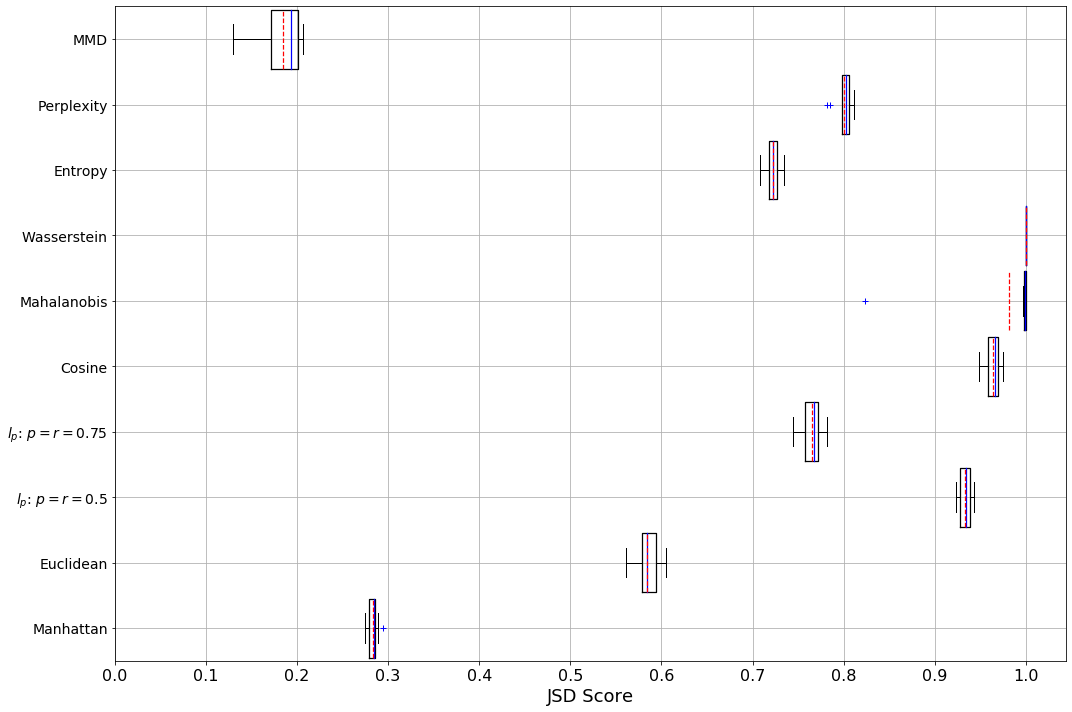

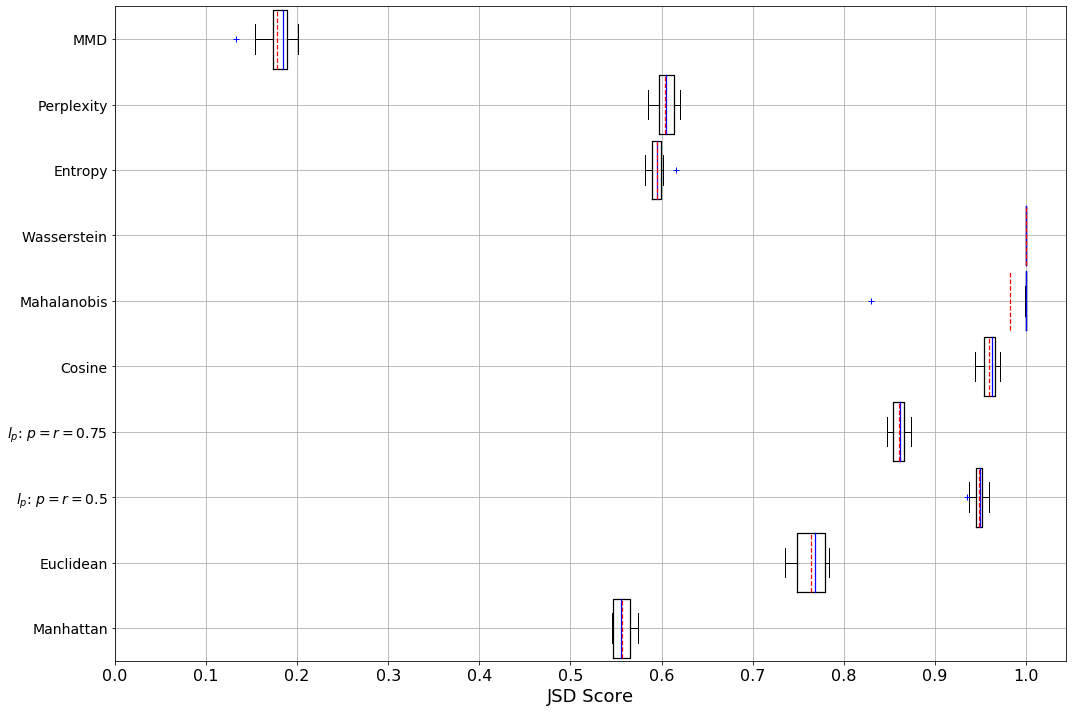

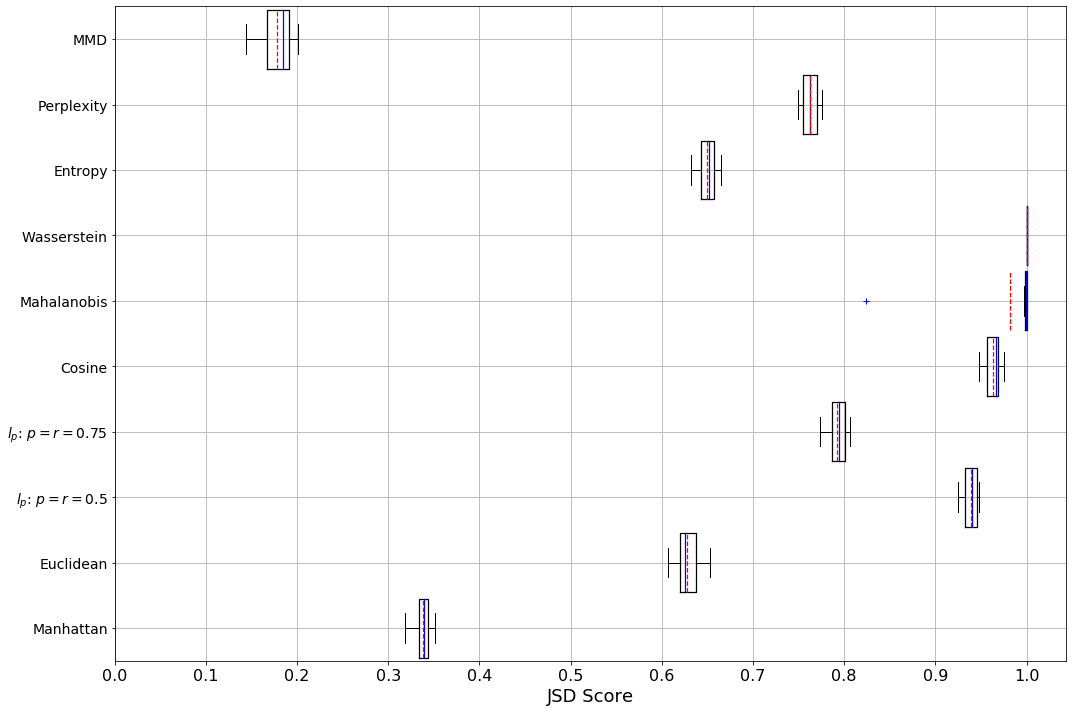

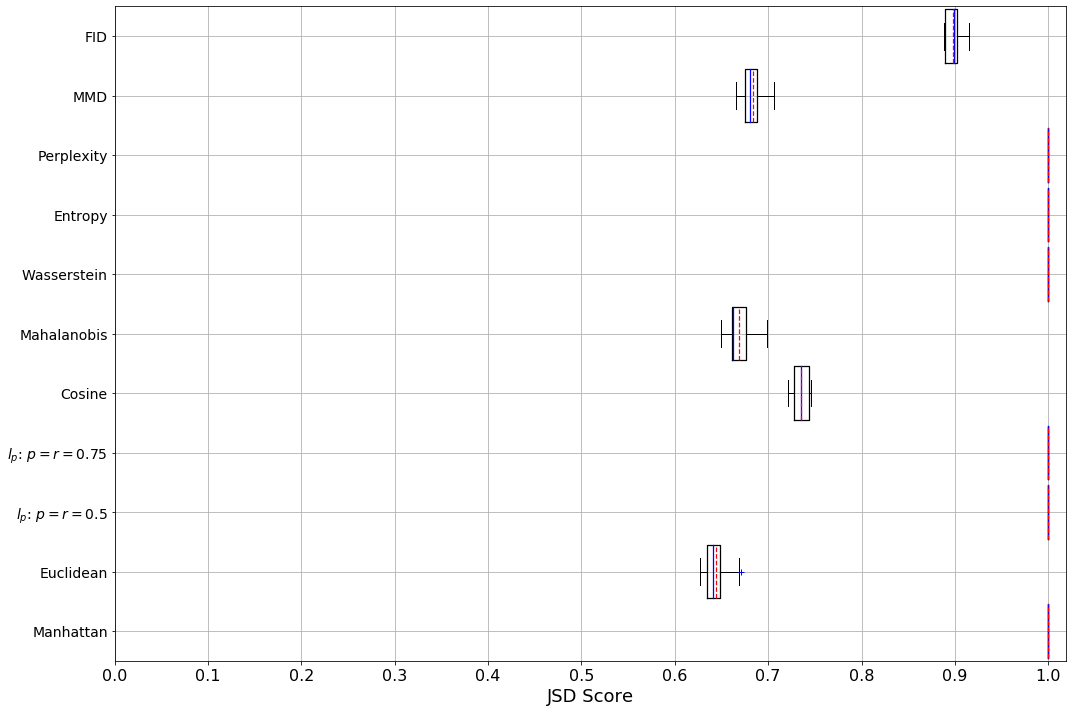

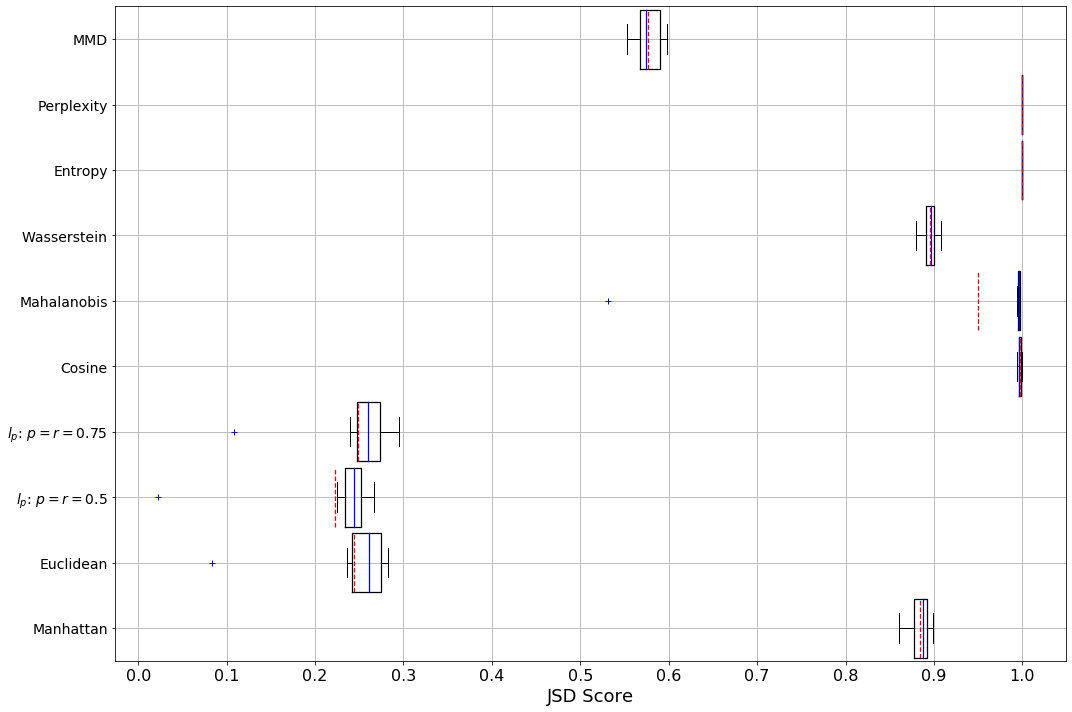

,0,1,2,3,4,5,6,7,8,9,10
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,10.000000
mean,0.612440,0.572674,0.808576,0.733242,0.923806,0.912869,0.979010,0.793358,0.833378,0.359961,0.897576
std,0.289796,0.179072,0.298405,0.259342,0.096510,0.145119,0.042595,0.175419,0.152831,0.225907,0.008653
min,0.274623,0.083857,0.022365,0.108499,0.721429,0.531596,0.880221,0.581331,0.585307,0.129235,0.887958
25%,0.333310,0.579031,0.925434,0.757269,0.947942,0.825231,1.000000,0.643444,0.754299,0.180517,0.889592
50%,0.555582,0.625310,0.940713,0.793951,0.965488,0.997745,1.000000,0.722676,0.802473,0.200792,0.898742
75%,0.892151,0.651360,0.951601,0.865491,0.972992,0.999875,1.000000,1.000000,1.000000,0.590079,0.901829
max,1.000000,0.783568,1.000000,1.000000,0.999500,1.000000,1.000000,1.000000,1.000000,0.706214,0.915151


0.022364713883728158


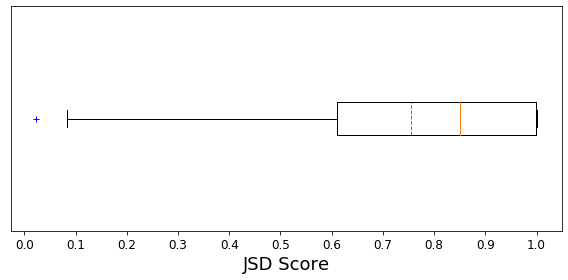

In [76]:
results_list = ['JSD_results_host_untrans_uniform.csv', 'JSD_results_host_sqrt_uniform.csv', 'JSD_results_host_log_uniform.csv', 
                'JSD_results_host_uniform_pca.csv', 'JSD_results_host_fft_uniform.csv']
#names = ['Manhattan', 'Euclidean',  r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
transforms = ['untrans', 'sqrt', 'log', 'pca', 'fft']
results_df = pd.DataFrame()
counter = 0
for file_name in results_list:
    names = ['Manhattan', 'Euclidean',  r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
    if 'pca' not in file_name:
        names = names[:10]
    df = pd.read_csv('results/'+file_name)
    temp = df.loc[:,'Run 1':'Run 10'].T
    results_df = results_df.append(temp)
    fig2 = plt.figure(figsize=(15,10))
    temp.columns = names
    bp = temp.boxplot( meanline=True, showmeans=True, vert=False, sym='b+', widths=0.9, return_type='dict')
    for median in bp['medians']:
        median.set(color='b', linewidth=1.25)
    for mean in bp['means']:
        mean.set(color='r', linewidth=1.25)
    for box in bp['boxes']:
        box.set(color='k',linewidth=1.25)
    for whisker in bp['whiskers']:
        whisker.set(color='k',linewidth=1.0)
    for cap in bp['caps']:
        cap.set(color='k',linewidth=1.0)
    plt.xlabel("JSD Score", fontsize=18)
    plt.xticks(np.arange(0,1.01,0.1),fontsize=16)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('/home/mnewlin/git/AFIT/Thesis/code/figures/discriminative/eps/box_whisker_host_uniform_{}.pdf'.format(transforms[counter]))
    plt.show()
    counter += 1
display(results_df.describe())
all_results_array = results_df.to_numpy().flatten()
all_results_array = all_results_array[~np.isnan(all_results_array)]
print(np.min(all_results_array))
fig = plt.figure(figsize=(8,4))
plt.boxplot(all_results_array, meanline=True, showmeans=True, vert=False, sym='b+')
plt.xticks(np.arange(0,1.01,0.1), fontsize=12)
plt.yticks([])
plt.xlabel("JSD Score", fontsize=18)
plt.tight_layout()
plt.savefig('/home/mnewlin/git/AFIT/Thesis/code/figures/discriminative/eps/box_whisker_host_uniform.pdf')
plt.savefig('/home/mnewlin/git/AFIT/Thesis/code/figures/discriminative/png/box_whisker_host_uniform.png')
plt.show()

In [ ]:
results_list = ['JSD_results_host_untrans_normal.csv', 'JSD_results_host_sqrt_normal.csv', 'JSD_results_host_log_normal.csv', 
                'JSD_results_host_normal_pca.csv', 'JSD_results_host_fft_normal.csv']
#names = ['Manhattan', 'Euclidean',  r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
transforms = ['untrans', 'sqrt', 'log', 'pca', 'fft']
results_df = pd.DataFrame()
counter = 0
for file_name in results_list:
    names = ['Manhattan', 'Euclidean',  r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
    if 'pca' not in file_name:
        names = names[:10]
    df = pd.read_csv('results/'+file_name)
    temp = df.loc[:,'Run 1':'Run 10'].T
    results_df = results_df.append(temp)
    fig2 = plt.figure(figsize=(15,10))
    temp.columns = names
    bp = temp.boxplot( meanline=True, showmeans=True, vert=False, sym='b+', widths=0.9, return_type='dict')
    for median in bp['medians']:
        median.set(color='b', linewidth=1.25)
    for mean in bp['means']:
        mean.set(color='r', linewidth=1.25)
    for box in bp['boxes']:
        box.set(color='k',linewidth=1.25)
    for whisker in bp['whiskers']:
        whisker.set(color='k',linewidth=1.0)
    for cap in bp['caps']:
        cap.set(color='k',linewidth=1.0)
    plt.xlabel("JSD Score", fontsize=18)
    plt.xticks(np.arange(0,1.01,0.1),fontsize=16)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('/home/mnewlin/git/AFIT/Thesis/code/figures/discriminative/eps/box_whisker_host_normal_{}.pdf'.format(transforms[counter]))
    plt.show()
    counter += 1
all_results_array = results_df.to_numpy().flatten()
all_results_array = all_results_array[~np.isnan(all_results_array)]
print(np.min(all_results_array))
fig = plt.figure(figsize=(8,4))
plt.boxplot(all_results_array, meanline=True, showmeans=True, vert=False, sym='b+')
plt.xticks(np.arange(0,1.01,0.1), fontsize=12)
plt.yticks([])
plt.xlabel("JSD Score", fontsize=18)
plt.tight_layout()
plt.savefig('/home/mnewlin/git/AFIT/Thesis/code/figures/discriminative/eps/box_whisker_host_normal.pdf')
plt.savefig('/home/mnewlin/git/AFIT/Thesis/code/figures/discriminative/png/box_whisker_host_normal.png')
plt.show()